In [2]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx
import re
# ref doc https://github.com/eliorc/node2ve and https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
from node2vec import Node2Vec 
from sklearn.model_selection import train_test_split
from music_utils import *
from tqdm.auto import tqdm  # import tqdm for progress bar
tqdm.pandas()

In [3]:
local = True
if local:
    DATA_PATH = '../Music_project/data/'
else:
    DATA_PATH = './data/'

# Creating edge list and feature matrix

## Importing data

In [8]:
spotify = pd.read_csv(DATA_PATH+'SpotifyFeatures.csv')
# Create a dictionary of the form {artist_name: artist_id}, sorted as they appear in the dataframe
# Here only artists appear that are the main artist for a song. 
# Create artist table
artist_dic = {a:str(b) for a,b in zip(sorted(spotify.artist_name.unique()), range(100, spotify.artist_name.nunique()+100))}
#sort by length 
artist_dic = dict(sorted(artist_dic.items(), key=lambda x: len(x[0]), reverse=True))


I did not see the added value of subsetting the columns of the dataframe (it's not too slow on the whole dataframe). In this way, we can also capture all the features immediately

A way we can make sure all values are captured is by replacing 'with' and 'par' by feat.
The thing we have to realize here is that we just make the graph larger in this way, it is not necessarily a huge problem if we fail to capture all. 

Here we make sure the different ways to announce a featuring are replaced by the standard (feat.) announcement in the track name. Then we split on the feat. announcement to obtain all artists that collaborate in a list. 

## Making a column with all artist id's and the number of artists per song

In [9]:
# Replace the artist names with artist_id's
def replace_artist_names(row, artist_dic, read=True, path='spotify_featured.pkl'):
    '''
    Parameters: 
        row: a row with all the characteristics of a song
        artist_dic: {artist_name: artist_id}
    Returns:
        for each song, a list of artist_id's that collaborated for the song
    '''
    # Perform the replacements using the replace() method
    artist_list = row.artists
    artist_list = artist_list.replace(', ', ',')
    artist_list = artist_list.replace(' & ', ',')
    artist_list = artist_list.replace(')', '')
    artist_list = re.split(',', artist_list)
    if artist_list == '':
        return [artist_dic[row.artist_name]]
    l_artists = [artist_id for artist_name, artist_id in artist_dic.items() if artist_name in artist_list]
    return [artist_dic[row.artist_name]] + l_artists

def spotify_featured(spotify, artist_dic, read=True, path='spotify_featured.pkl', DATA_PATH=DATA_PATH):
    
    if read:
        spotify = pd.read_pickle(DATA_PATH + path)
    else:
        # Splitting the track name to obtain all artists collaborating on the song
        print('tack_name replacement')
        spotify['track_name'] = spotify.track_name.progress_apply(lambda x: x.replace('(with ', '(feat. '))
        
        print('artists split')
        spotify['artists'] = spotify.track_name.progress_apply(lambda x:x.split('(feat. ')[1] if '(feat. ' in x else '')

        # Put all artists collaborating on the song in a list and retrieve the length of the list. 
        print('artists to ids')
        spotify['artists'] = spotify.progress_apply(lambda row: replace_artist_names(row, artist_dic), axis=1)

        print('number of artists')
        spotify['num_artists'] = spotify.artists.progress_apply(lambda x:len(x))

        #save the df
        spotify.to_pickle(DATA_PATH+'spotify_featured.pkl')
    
    return spotify


In [10]:
spotify = spotify_featured(spotify, artist_dic, read=False)

tack_name replacement


  0%|          | 0/232725 [00:00<?, ?it/s]

artists split


  0%|          | 0/232725 [00:00<?, ?it/s]

artists to ids


  0%|          | 0/232725 [00:00<?, ?it/s]

number of artists


  0%|          | 0/232725 [00:00<?, ?it/s]

In [12]:
spotify = spotify_featured(spotify, artist_dic, read=True)

Perform some checks: here we see that Sia is featured and the main artist, so would have a self loop. 

In [13]:
spotify[spotify['track_id'] == '2c7GlMNmF7pbohjykutmLP']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists,num_artists
9072,Dance,Sia,"Thunderclouds (feat. Sia, Diplo & Labrinth)",2c7GlMNmF7pbohjykutmLP,86,0.0085,0.691,187027,0.716,0.000009,G,0.263,-5.985,Major,0.0351,112.035,4/4,0.507,"[11400, 7335, 3477, 11400]",4
108040,Pop,Sia,"Thunderclouds (feat. Sia, Diplo & Labrinth)",2c7GlMNmF7pbohjykutmLP,86,0.0085,0.691,187027,0.716,0.000009,G,0.263,-5.985,Major,0.0351,112.035,4/4,0.507,"[11400, 7335, 3477, 11400]",4


In [14]:
# this one we don't capture
spotify[spotify['track_id'] == '7sO5G9EABYOXQKNPNiE9NR']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists,num_artists
66646,Hip-Hop,Offset,Ric Flair Drip (& Metro Boomin),7sO5G9EABYOXQKNPNiE9NR,86,0.149,0.88,172800,0.428,0.000051,A,0.114,-8.28,Major,0.206,100.007,4/4,0.333,[9535],1
86994,Rap,Offset,Ric Flair Drip (& Metro Boomin),7sO5G9EABYOXQKNPNiE9NR,86,0.149,0.88,172800,0.428,0.000051,A,0.114,-8.28,Major,0.206,100.007,4/4,0.333,[9535],1
107857,Pop,Offset,Ric Flair Drip (& Metro Boomin),7sO5G9EABYOXQKNPNiE9NR,86,0.149,0.88,172800,0.428,0.000051,A,0.114,-8.28,Major,0.206,100.007,4/4,0.333,[9535],1


In [15]:
# this one we don't capture ( we could change the second feat. into a comma)
spotify[spotify['track_id'] == '4mGdjNMo0RonTlOEb7cYg4']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists,num_artists
77053,Children’s Music,YUNGBLUD,11 Minutes (feat. Halsey feat. Travis Barker),4mGdjNMo0RonTlOEb7cYg4,86,0.0116,0.464,239507,0.852,0.0,B,0.108,-3.804,Major,0.067,160.075,4/4,0.233,[14230],1
92825,Indie,YUNGBLUD,11 Minutes (feat. Halsey feat. Travis Barker),4mGdjNMo0RonTlOEb7cYg4,87,0.0116,0.464,239507,0.852,0.0,B,0.108,-3.804,Major,0.067,160.075,4/4,0.233,[14230],1
166060,Rock,YUNGBLUD,11 Minutes (feat. Halsey feat. Travis Barker),4mGdjNMo0RonTlOEb7cYg4,87,0.0116,0.464,239507,0.852,0.0,B,0.108,-3.804,Major,0.067,160.075,4/4,0.233,[14230],1


## Creating an edge list

In [ ]:
spotify = spotify[spotify.num_artists > 1].copy()
nodes_df = nodes_featuring(spotify,read=False)

## Saving the feature matrix per song and the edge list

In [35]:
nodes_df

,artist_1,artist_2,num_feats,track_ids
0,10016,1922,2,"[480xW0fw6PqOjhnEce1gNb, 0Yb3VlcpCEaVL1e3nXOQSY]"
1,10016,4102,1,[1Vvk2a6FQY2A39HzQuuzhO]
2,10024,12640,1,[13JToOBNkO00YLQ60ukhDY]
3,10024,214,1,[22hKWurlF1TLHORdA6Xbmk]
4,10024,6660,1,[13JToOBNkO00YLQ60ukhDY]
...,...,...,...,...
4422,9440,9705,5,"[5YY7ht3PCArlLjLbcTiAvh, 5YY7ht3PCArlLjLbcTiAv..."
4423,9446,9878,1,[5mEDUOQCGhCeklWCWKaEgI]
4424,9535,9946,1,[6lsazhI7G23SdJ47pfSAMZ]
4425,9596,9596,4,"[0Q3SC6kEhxYagDP3bFe5K9, 0Q3SC6kEhxYagDP3bFe5K..."


From this dataframe, it is easy to create an edge_list that can be passed to networkx

In [37]:
edge_list = [tuple(l[:2]) for l in nodes_df.values.tolist()]

In [38]:
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 1608 nodes.
The largest connected component has 4081 edges.


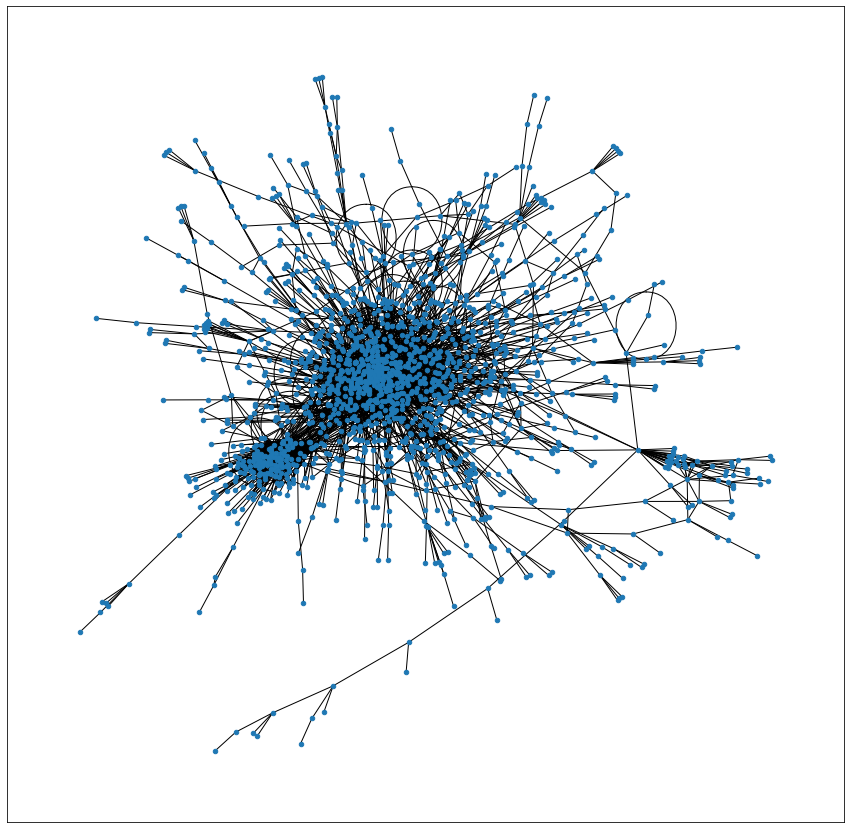

In [39]:
# didn't work on my local computer, but did work on colab, some issue with the installed networkx version
fig, ax = plt.subplots(figsize=(15, 15))
ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)

We currently have: 

1) an edge list with which we can greate a graph. 

2) a dataframe with per song all the features (genre,...)

The next step is to

1) possibly finetune the way in which we make the edge list. For example, we can 

2) from the dataframe with all the features per song, make features for artists. 

# Spotify 600k songs

In [4]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=True)

In [8]:
#Nodes creation
feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=False, path='edge_list_600k_over1999.pkl')

#artists feature creation
artists_600_features = artists_features_creation(artists_600, spotify_600, DATA_PATH, read=True)

In [9]:
edge_list = [tuple(l[:2]) for l in nodes_600.values.tolist()]
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 20805 nodes.
The largest connected component has 63630 edges.


In [ ]:
# didn't work on my local computer, but did work on colab, some issue with the installed networkx version
fig, ax = plt.subplots(figsize=(15, 15))
ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)

We currently have: 

1) an edge list with which we can greate a graph. 

2) a dataframe with per song all the features (genre,...)

3) a dataframe with per artist lots of features:
- popularity, followers, genres, number of genres
- solo song features
- initiated featurings features (featurings s.he is the main artist i.e first in artist list)
- member featurings features (featurings s.he is part of but not the main artist)

The issues about featurings cleaning is not necessary to work on as the new dataset is cleaning regarding it.

The next step is to (to complete):

1. Select the genres that are musics (some are like podcasts, movies, series...)
2. Define the border of our analysis: everything since 1920 ? time-based analysis?
3. Start doing ML/NN models